In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import hemcee

import jax
import jax.numpy as jnp
# JAX defaults to 32-bit precision. Now we default to 64-bit precision.
jax.config.update("jax_enable_x64", True) 

import corner

# Target Distribution

Here we construct a the log probability of a multivariate Gaussian distribution.
What's nice about JAX is that we don't have to natively make the function parallelize,
but rather, we can use the `vmap` functionality to parallelize our function.

The samplers in `hemcee` assume your function was not parallelized, and will use `vmap` to do this for you.

In [34]:
dim = 5
cond_number = 1000

eigenvals = 0.1 * jnp.linspace(1, cond_number, dim)
H = jax.random.normal(jax.random.PRNGKey(0), (dim, dim))
Q, _ = jnp.linalg.qr(H)
precision = Q @ jnp.diag(eigenvals) @ Q.T
precision = 0.5 * (precision + precision.T)

def log_prob(x):
    return 0.5 * jnp.einsum('i,ij,j->', x, precision, x)

# Sampler

To use `hemcee`, you need to
1. Initalize the sampler, and set the leapfrog integrator's parameters
2. Run the MCMC

In [39]:
total_chains = dim * 4
step_size_init = 0.1
L = 10

sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    step_size=step_size_init,
    L=L,
)

In [40]:
inital_states = jax.random.normal(jax.random.PRNGKey(0), shape=(total_chains, dim))

samples, diagnostics = sampler.run_mcmc(
    key=jax.random.PRNGKey(0),
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
    adapt_step_size=True,
)
print(diagnostics)

Using 20 total chains: Group 1 (10), Group 2 (10)
{'acceptance_rate': Array(0.95, dtype=float64), 'dual_averaging_state': DAState(step_size=Array(0.99100855, dtype=float64), H_bar=Array(1.54984502e-05, dtype=float64), log_epsilon_bar=Array(-0.00903211, dtype=float64)), 'step_size': Array(0.99100855, dtype=float64)}


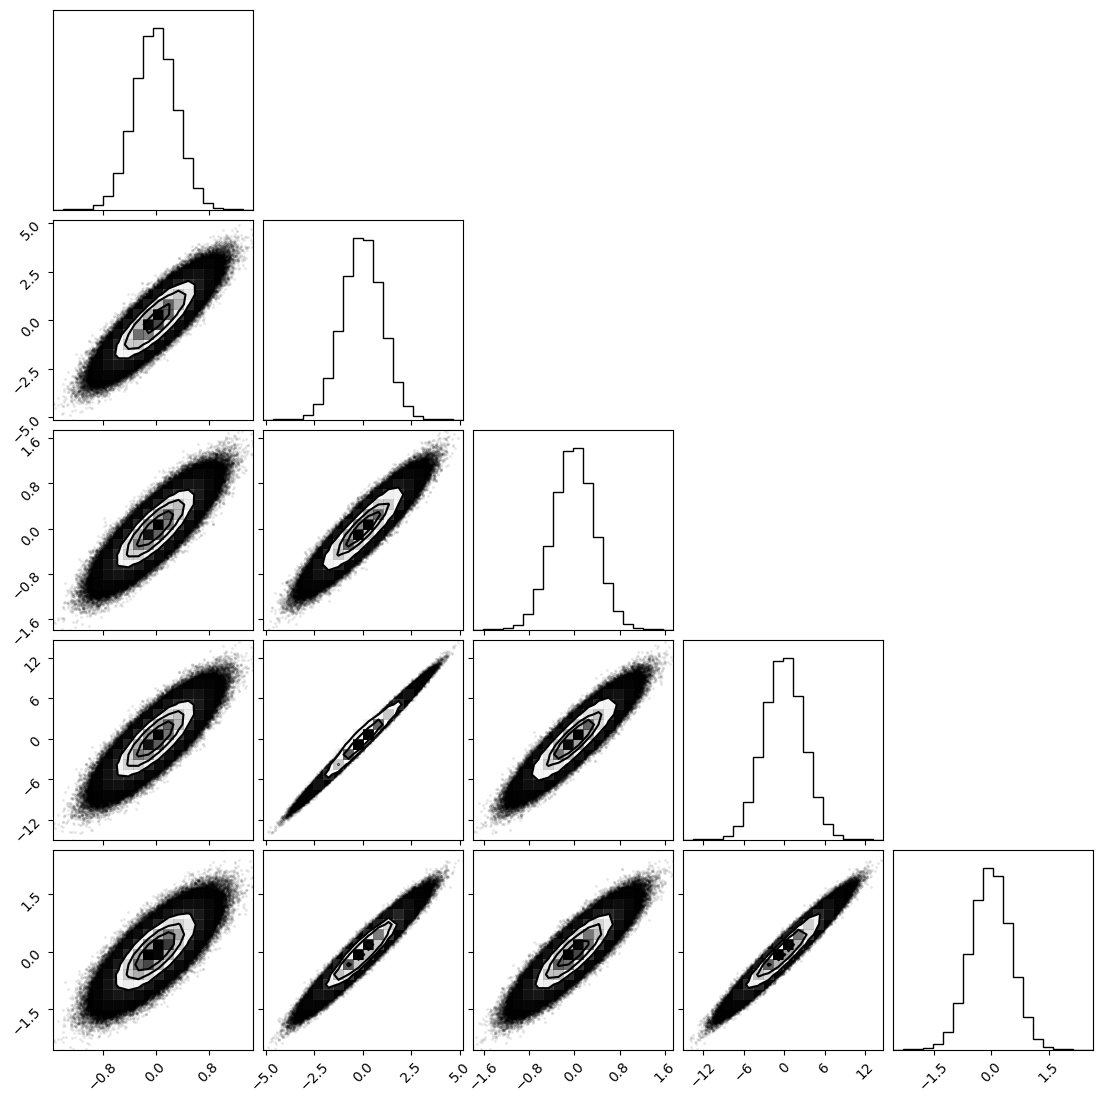

In [41]:
_ = corner.corner(np.array(samples).reshape(-1, dim))